# Binary Wet Snow Map Time Series: Mt. Rainier 2020

In [2]:
import numpy as np
import geopandas as gpd
import rasterio as rio
import matplotlib.pyplot as plt
import contextily as ctx
import xarray as xr
import rioxarray as rxr
import dask_gateway
import sys
sys.path.append('../../../sar_snowmelt_timing')
sys.path.append('../../../../generate_sentinel1_local_incidence_angle_maps')
import s1_rtc_bs_utils
import generate_lia
import pandas as pd

In [3]:
# cluster = dask_gateway.GatewayCluster()
# client = cluster.get_client()
# cluster.adapt(minimum=2, maximum=100)
# print(client.dashboard_link)

# Read in bounding box geojson

In [4]:
name = 'Banded Peak Ranch'
geojson = '../../../input/shapefiles/bpr.geojson'     

# Get Sentinel-1 data over the bounding box

In [5]:
bbox_gdf = gpd.read_file(geojson)
ts_ds = s1_rtc_bs_utils.get_s1_rtc_stac_pc(bbox_gdf,start_time='2020-01-01',end_time='2020-12-31',polarization='all')

/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


# Check out the xarray dataarray

In [6]:
ts_ds

<xarray.DataArray 'stackstac-7be407f5cd87b5fa4c8acfd31c171ea9' (time: 111,
                                                                band: 2,
                                                                y: 2528, x: 2027)>
dask.array<getitem, shape=(111, 2, 2528, 2027), dtype=float32, chunksize=(1, 1, 512, 512), chunktype=numpy.ndarray>
Coordinates: (12/39)
  * time                                   (time) datetime64[ns] 2020-01-05T0...
    id                                     (time) <U66 'S1B_IW_GRDH_1SDV_2020...
  * band                                   (band) <U2 'vh' 'vv'
  * x                                      (x) float64 1.937e+06 ... 1.978e+06
  * y                                      (y) float64 4.262e+06 ... 4.211e+06
    sar:observation_direction              <U5 'right'
    ...                                     ...
    sar:resolution_range                   int64 20
    s1:total_slices                        (time) <U2 '17' '18' ... '29' '29'
    description                            (band) <U173 'Terrain-corrected ga...
    raster:bands                           object {'nodata': -32768, 'data_ty...
    title                                  (band) <U41 'VH: vertical transmit...
    epsg                                   int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(1937220, 4211180, 1978020, 42...
    crs:         epsg:32610
    transform:   | 20.00, 0.00, 1937220.00|\n| 0.00,-20.00, 4262060.00|\n| 0....
    resolution:  20

# Sentinel-1 Overpass Times Context

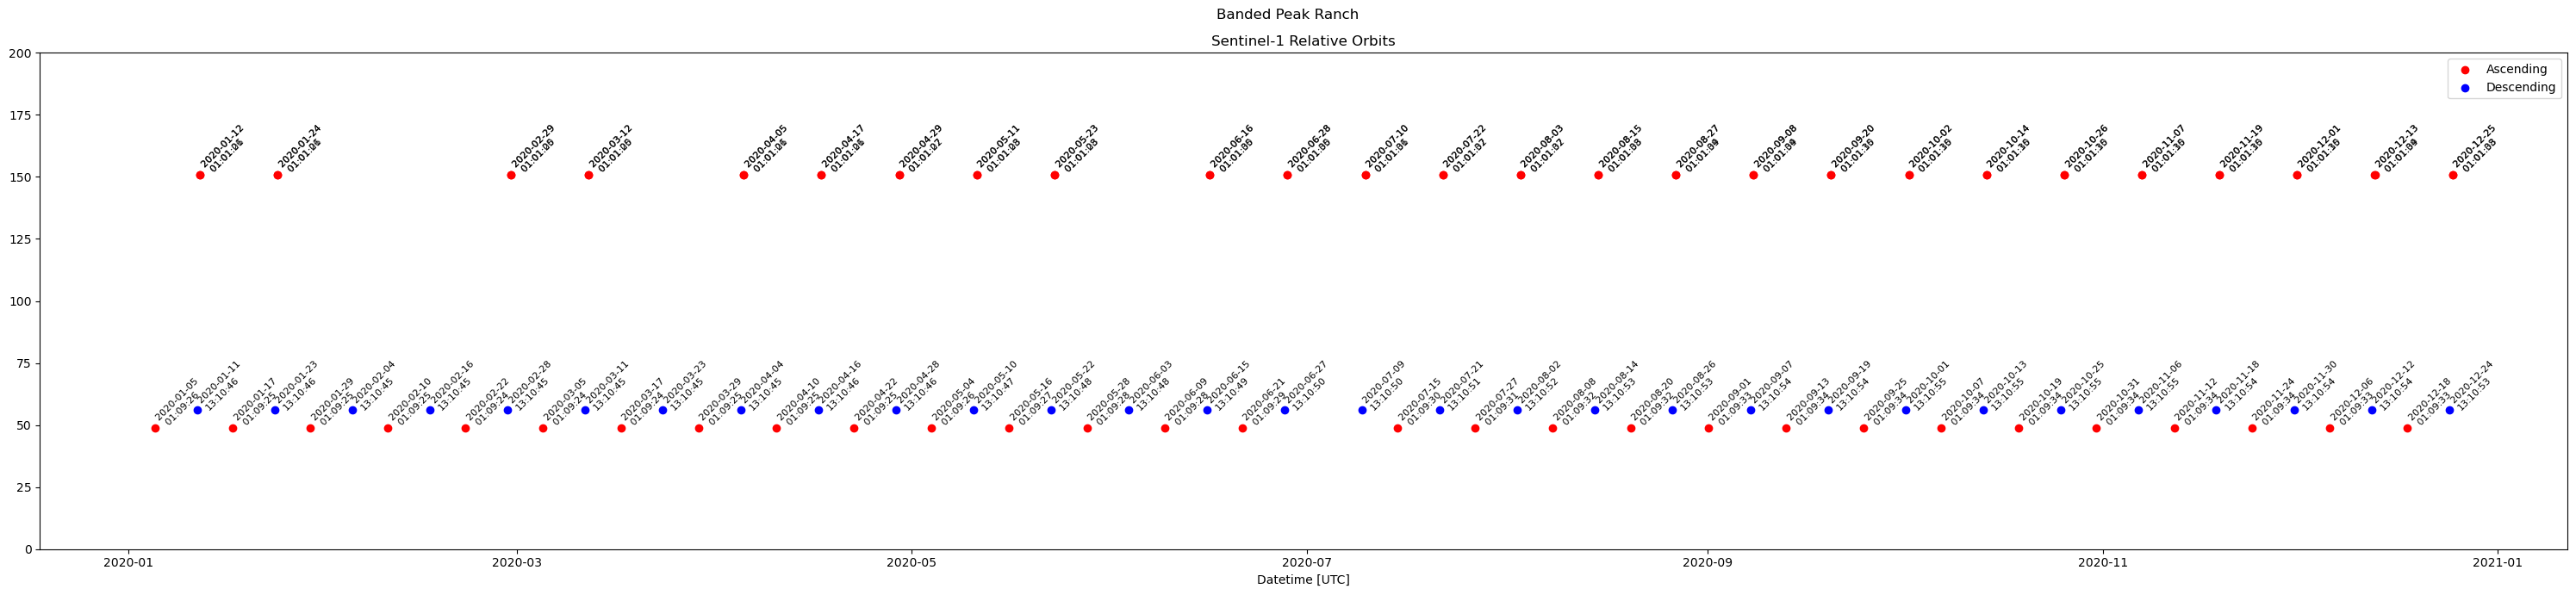

In [7]:
f,ax=plt.subplots(figsize=(30,7))
    
s1_rtc_bs_utils.plot_sentinel1_acquisitons(ts_ds,ax=ax)

f.suptitle(f'{name}')
plt.tight_layout()

# Mask out treecover

In [8]:
classes = [ # page 13 of https://esa-worldcover.s3.amazonaws.com/v100/2020/docs/WorldCover_PUM_V1.0.pdf
#    10, # treecover
    20, # shrubland
    30, # grassland
    40, # cropland
#    50, # built-up
    60, #bare / sparse vegetation
    70, # snow and ice
#    80, # permanent water bodies
    90, # herbaceous wetlands
    95, # mangroves
    100 # loss and lichen
]

In [9]:
worldcover = s1_rtc_bs_utils.get_worldcover(ts_ds)
ts_ds = ts_ds.where(worldcover.isin(classes))

/srv/conda/envs/notebook/lib/python3.11/site-packages/pystac_client/item_search.py:826: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


# Convert to dB

In [10]:
ts_ds_db = 10.0*np.log10(ts_ds)

# Now let's find the summertime average backscatter for each orbit and polarization

In [11]:
summer = slice('2020-06-01','2020-09-01')

In [12]:
summer_db = ts_ds_db.sel(time=summer).groupby('sat:relative_orbit').mean()

# Now let's subtract these summer averages from the time series to get ratio images for all polarizations and orbits

In [13]:
ratio_images = ts_ds_db.groupby('sat:relative_orbit')-summer_db

/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 29 times more chunks
  return self.array[key]


# Let's view a time series of the VV and VH ratio images for the month of December

In [14]:
december = slice('2020-12-01','2020-12-31')

In [15]:
ratio_images_december = ratio_images.sel(time=december).compute()

/tmp/ipykernel_1012/3714251087.py:2: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in ratio_images_december_plot.axes.flatten():


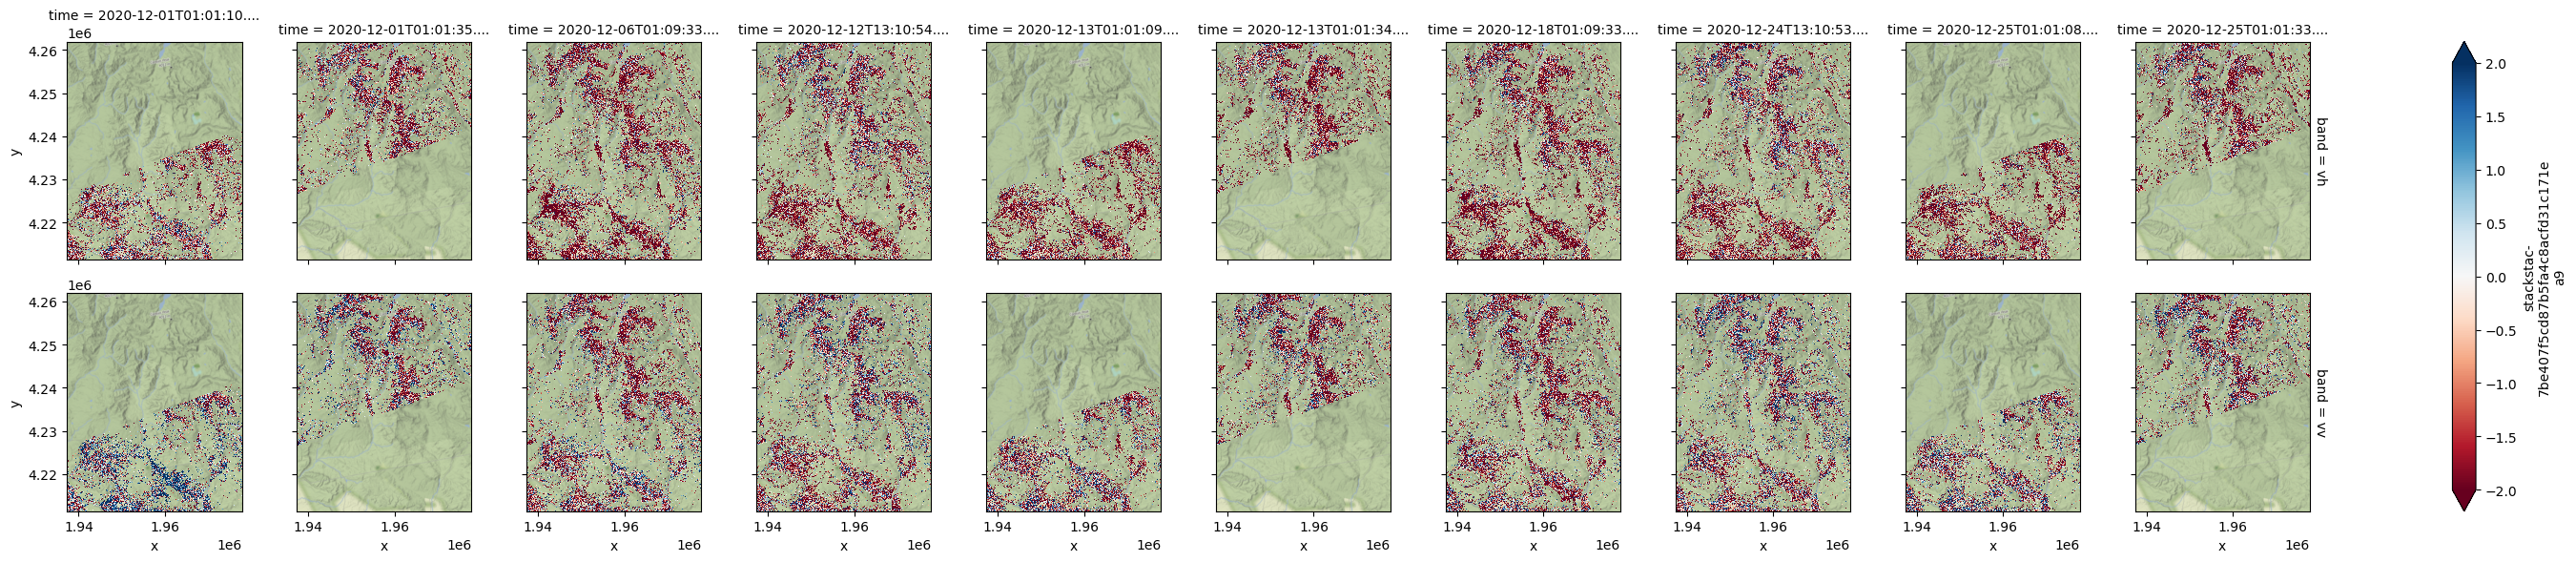

In [16]:
ratio_images_december_plot = ratio_images_december.plot(row='band',col='time',vmin=-2,vmax=2,cmap='RdBu')
for ax in ratio_images_december_plot.axes.flatten():
    ctx.add_basemap(ax=ax, crs=ratio_images_december.rio.crs, source='https://tiles.stadiamaps.com/tiles/stamen_terrain/{z}/{x}/{y}{r}.jpg?api_key=25e388f2-410e-435e-a401-ca7ef32eada0', attribution=False)

# Now we can combine the ratio images from the VV and VH polarizations using the method from Nagler et al. 2016 making use of local incidence angle. See https://www.mdpi.com/2072-4292/8/4/348

In [17]:
# # Bring in LIA data
# local_incidence_angles = s1_rtc_bs_utils.get_s1_rtc_stac(bbox_gdf,
#                                                          polarization='incidence',
#                                                          collection='../input/sentinel1-rtc-aws/mycollection_rainier.json')

In [18]:
#generate_lia.geojson_to_lia_rasters_and_lia_stack(geojson,res=20)

In [19]:
lia_stack = xr.open_dataarray('lia_maps/lia_stack_orbits_49_56_151.nc',decode_coords='all')
mean_local_incidence_angles = np.rad2deg(lia_stack)

In [20]:
dem = rxr.open_rasterio('dems/dem_UTM.tif')

In [21]:
# # Take the LIA mean per relative orbit
# mean_local_incidence_angles = local_incidence_angles[local_incidence_angles['sat:relative_orbit'].isin(ratio_images['sat:relative_orbit'])].groupby('sat:relative_orbit').median() #is mean best to use here?

In [22]:
# Write crs to LIA raster and reproject to match ratio images
mean_local_incidence_angles = mean_local_incidence_angles.rio.write_crs(dem.rio.crs)
lia = mean_local_incidence_angles.rio.reproject_match(ratio_images)

In [23]:
# mask out LIA <15 and >75
lia = lia.where((lia>15) & (lia<75))

Text(0.5, 1.05, 'Local incidence angle rasters per relative orbit')

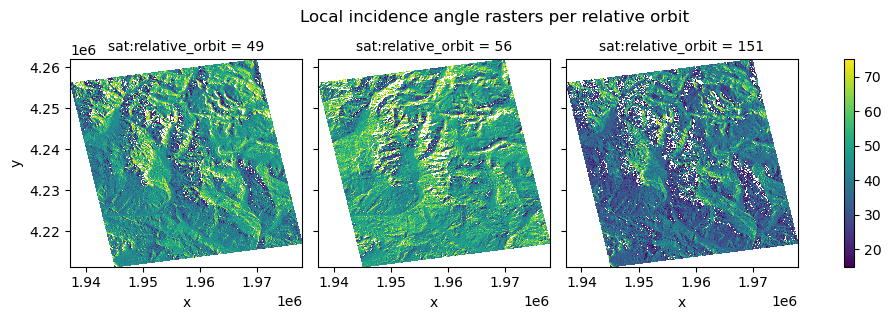

In [24]:
# Lets look at the masked LIA rasters
lia.plot(col='sat:relative_orbit')
plt.suptitle('Local incidence angle rasters per relative orbit',y=1.05)

In [25]:
# Constants to be used in the weights calculation
k = 0.5
theta1 = 20
theta2 = 45

In [26]:
# Weights calculation per relative orbit
W = xr.where(lia<theta1,1,k*(1 + ((theta2-lia)/(theta2-theta1)) ) )
W = xr.where(lia>theta2,k,W)

Text(0.5, 1.05, 'Weight (W) values per relative orbit')

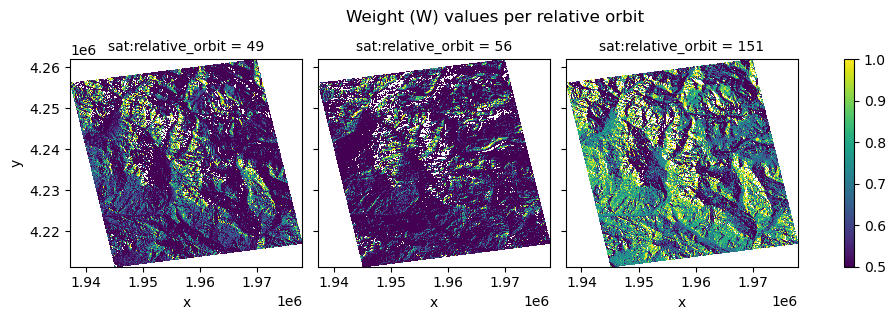

In [27]:
# View weights, note the bad incidence angles masked out
W.plot(col='sat:relative_orbit')
plt.suptitle('Weight (W) values per relative orbit',y=1.05)

# Now that we've calculated the weights, let's combine the VV and VH ratio images and resample to 100m

In [28]:
# Rc calculation
Rc = W*ratio_images.sel(band='vh').groupby('sat:relative_orbit') + (1-W)*ratio_images.sel(band='vv').groupby('sat:relative_orbit') 

In [29]:
# Resample to 100m, using median resampling
Rc = Rc.rio.write_crs(lia.rio.crs)
Rc_100 = Rc.rio.reproject(Rc.rio.crs, resolution=100, resampling=rio.enums.Resampling.med)

# Now threshold the images using a threshold of -2dB

In [30]:
binary_wet_snow = xr.where(Rc_100<-2,1,np.nan)

# Remove single outlier pixels

In [31]:
# 3x3 median filter:toggle min_periods, should change to 1 for single pixel outlier
binary_wet_snow = binary_wet_snow.rolling({"x":3,"y":3},center=True,min_periods=2).median()

In [ ]:
# time_index = pd.DatetimeIndex(binary_wet_snow['time'].values)

# # Group by 1-minute bins and aggregate by mean (you can change the aggregation method if needed)
# binary_wet_snow_merge = binary_wet_snow.groupby_bins('time', pd.date_range(start=time_index.min(), end=time_index.max(), freq='1T')).mean()

In [ ]:
# clipping

In [70]:
watershed0 = gpd.read_file('../../../input/shapefiles/NavajoRiver/NavajoRiver_Basin_toBPRGauge.shp')
watershed1 = gpd.read_file('../../../input/shapefiles/NavajoRiver/NavajoRiver_Basin_toOsoDiv.shp')
watershed = watershed0.union(watershed1).to_crs(binary_wet_snow_merge.rio.crs)

In [75]:
binary_wet_snow_merge = binary_wet_snow.resample(time='1W').max().rio.clip(watershed.geometry.values,watershed.crs)

# Let's view a time series of binary wet snow maps for all of 2020 to see if it makes sense

/tmp/ipykernel_1012/4117633795.py:2: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in binary_wet_snow_plot.axes.flatten():


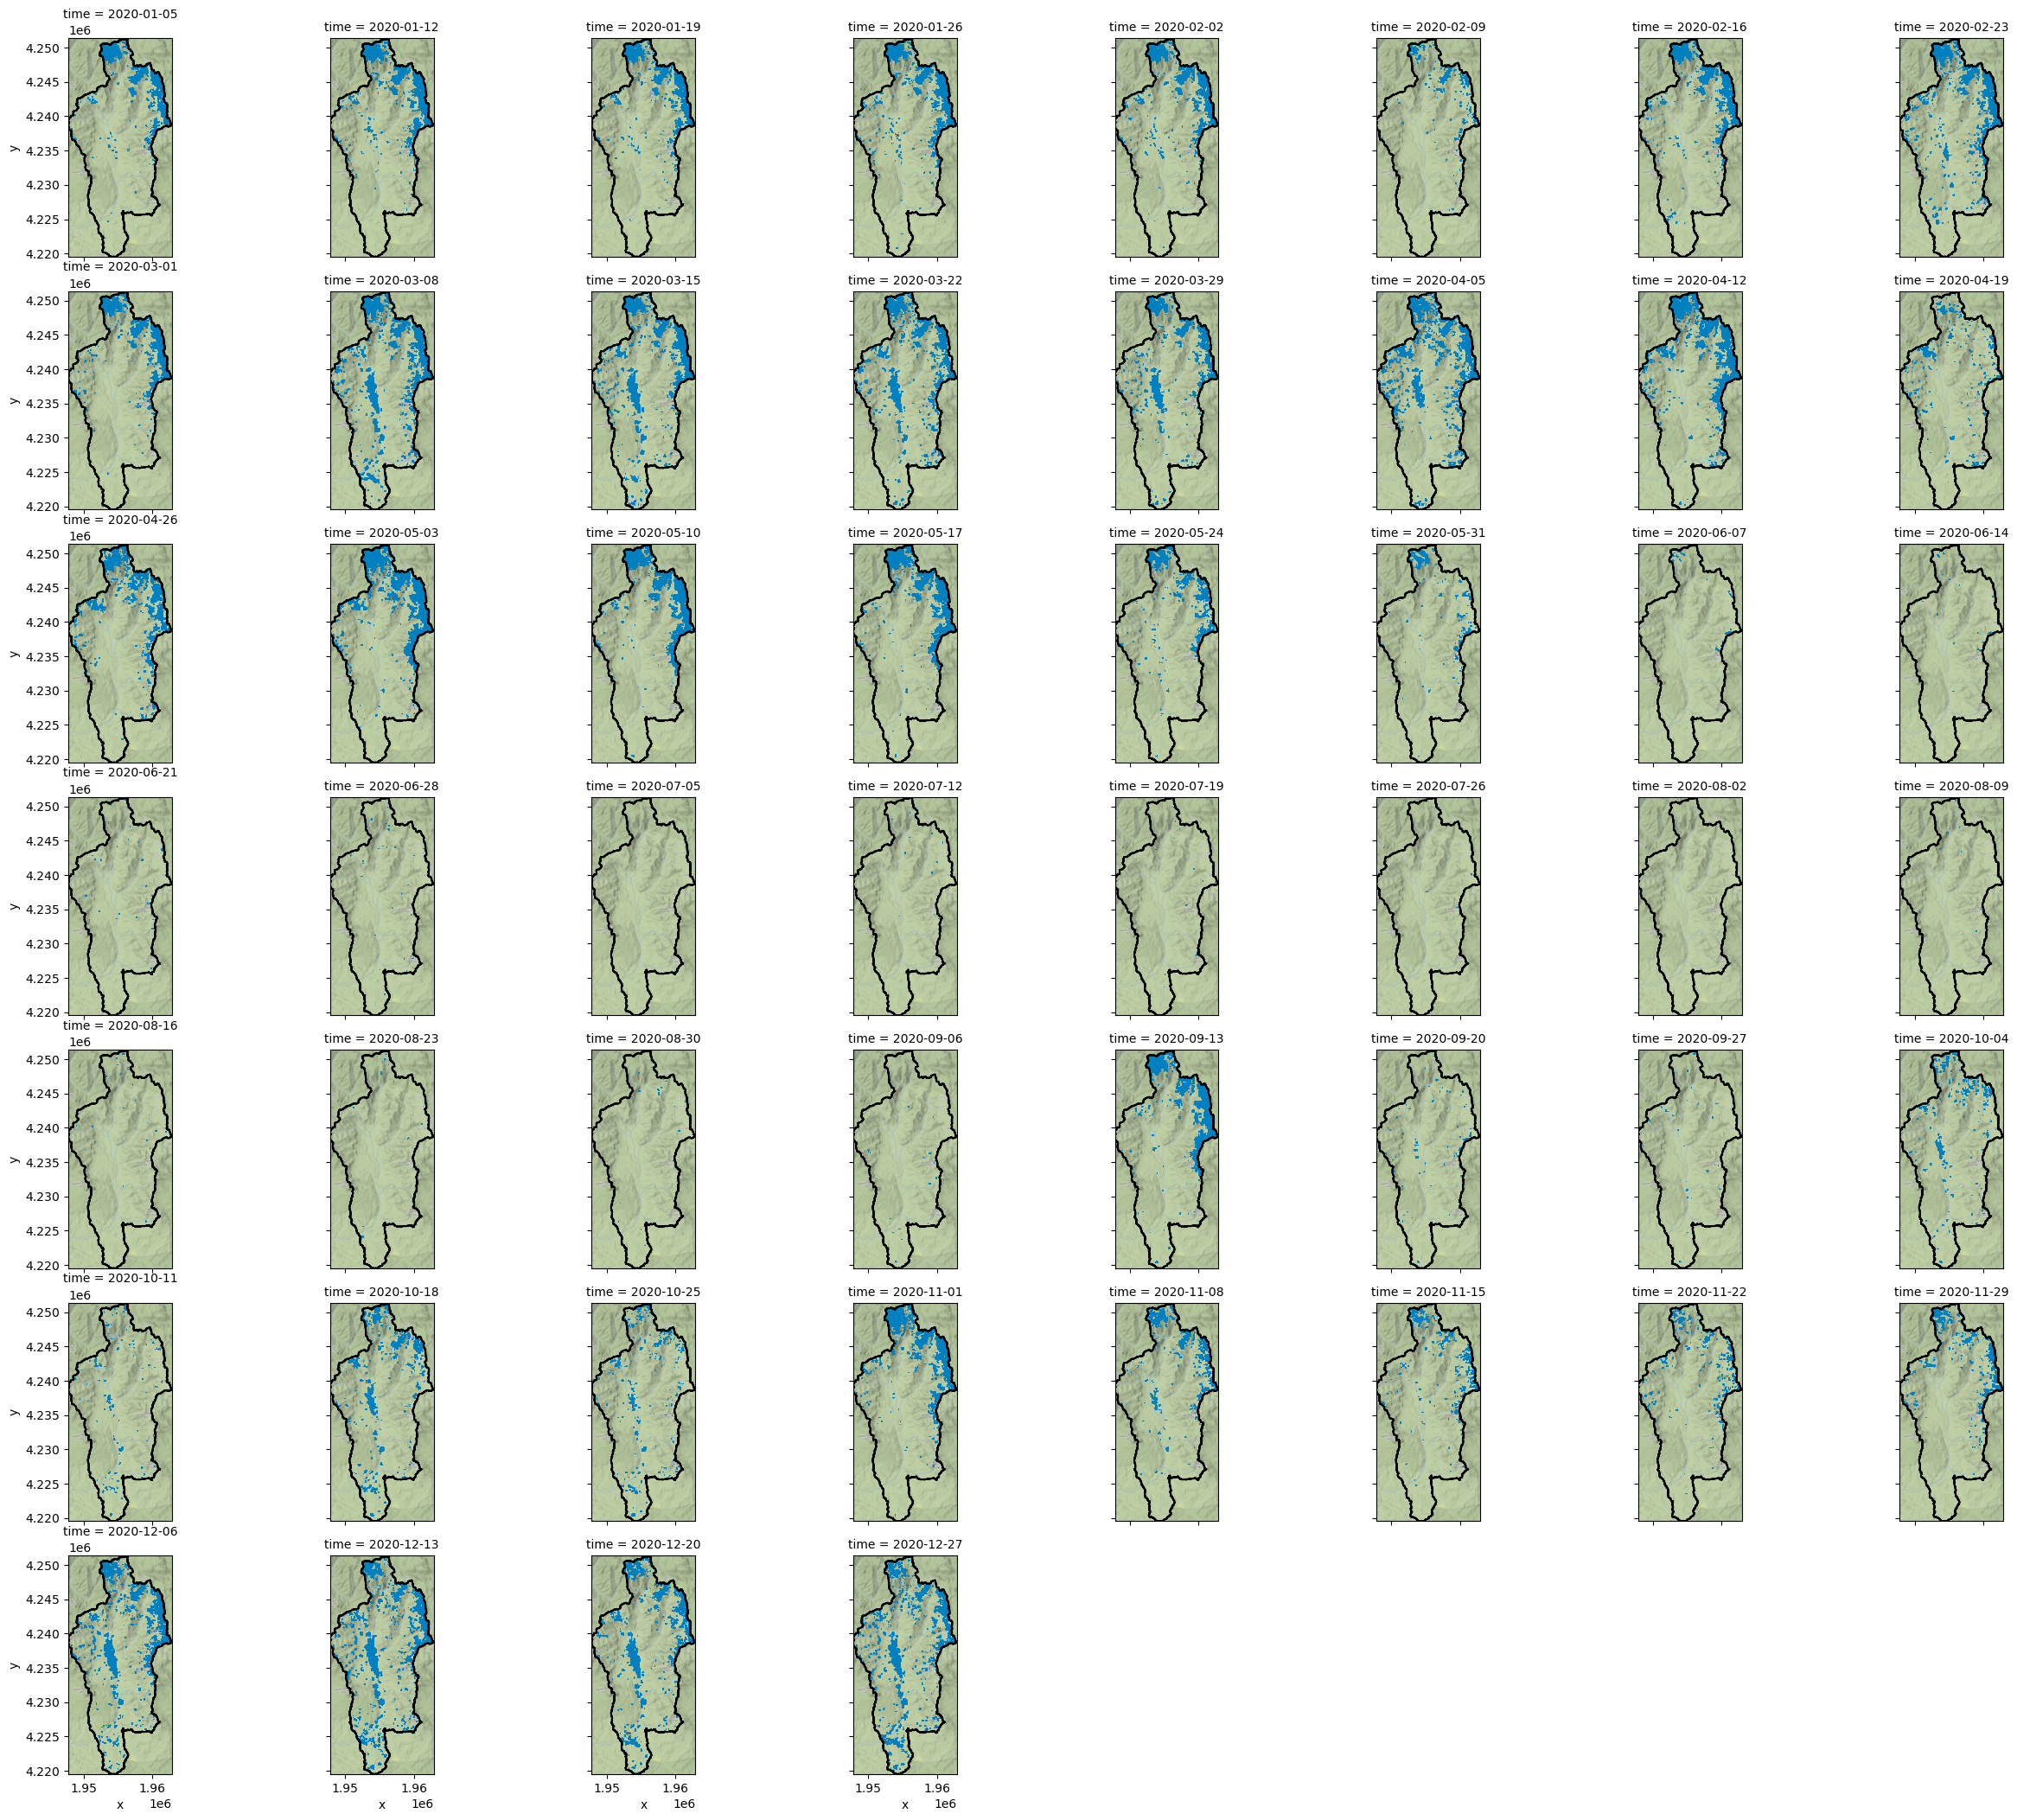

In [76]:
binary_wet_snow_plot = binary_wet_snow_merge.plot(col='time',vmin=1,add_colorbar=False,col_wrap=8,cmap='winter')
for ax in binary_wet_snow_plot.axes.flatten():
    ctx.add_basemap(ax=ax, crs=binary_wet_snow.rio.crs, source='https://tiles.stadiamaps.com/tiles/stamen_terrain/{z}/{x}/{y}{r}.jpg?api_key=25e388f2-410e-435e-a401-ca7ef32eada0', attribution=False)
    watershed.geometry.boundary.plot(ax=ax,color='black')

In [77]:
# Looks as expected! i think a gif of this would look pretty cool, maybe a second pane with evolution of temperature across elevations for each frame too.

In [78]:
import matplotlib.animation as animation
import IPython

CPU times: user 11.8 s, sys: 510 ms, total: 12.3 s
Wall time: 12.6 s


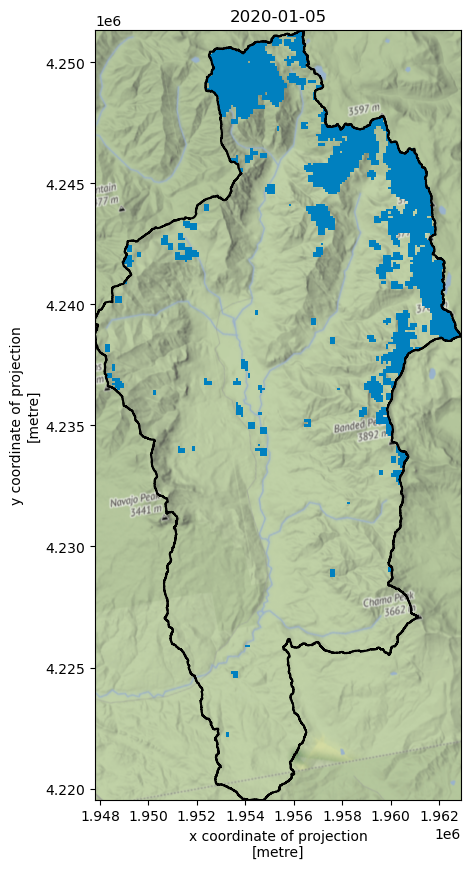

In [80]:
%%time

fig, ax = plt.subplots(figsize=(10,10))

im = binary_wet_snow_merge.isel(time=0).plot(ax=ax,vmin=1,cmap='winter',add_colorbar=False)
ctx.add_basemap(ax=ax, crs=binary_wet_snow_merge.rio.crs, source='https://tiles.stadiamaps.com/tiles/stamen_terrain/{z}/{x}/{y}{r}.jpg?api_key=25e388f2-410e-435e-a401-ca7ef32eada0', attribution=False)
watershed.geometry.boundary.plot(ax=ax,color='black')
def update(i):
    im.set_array(binary_wet_snow_merge.isel(time=i))
    ax.set_title(f'{binary_wet_snow_merge.time.isel(time=i).dt.date.values}')
    return im,

ani = animation.FuncAnimation(fig, update, interval=400, frames=range(len(binary_wet_snow_merge.time)), blit=False,
                                repeat_delay=1000)

ani.save("BPR_binary_wet_snow_timeseries.mp4")